# Optimizer Example
Jena Climate RNN example showing comparison between Adam and other optimizers available when it was introduced.
This is a regression model, using 3-hour data.

Richard Henry, 26-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.style.use('fivethirtyeight')

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.17.0'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena 3hr|RNN|Contemporary|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.17 s
Wall time: 2.4 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    return model
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 133.6968 - mean_absolute_error: 9.5396 - val_loss: 72.8394 - val_mean_absolute_error: 6.8659
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - loss: 50.6521 - mean_absolute_error: 5.6514 - val_loss: 39.9792 - val_mean_absolute_error: 4.8487
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - loss: 29.8080 - mean_absolute_error: 4.2424 - val_loss: 29.7555 - val_mean_absolute_error: 4.1614
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - loss: 23.4407 - mean_absolute_error: 3.7490 - val_loss: 24.9339 - val_mean_absolute_error: 3.7976
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - loss: 20.7261 - mean_absolute_error: 3.5274 - val_loss: 22.5074 - val_mean_absolute_error: 3.6171
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - loss: 18.7073 - mean_absolute_error: 3.3566 - val_loss: 20.1134 - val_mean_absolute_error: 3.4068
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - loss: 16.9661 - me

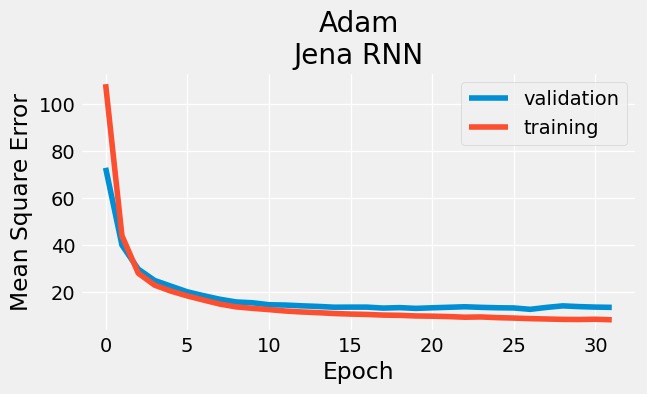

In [13]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h0.history['loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.show()

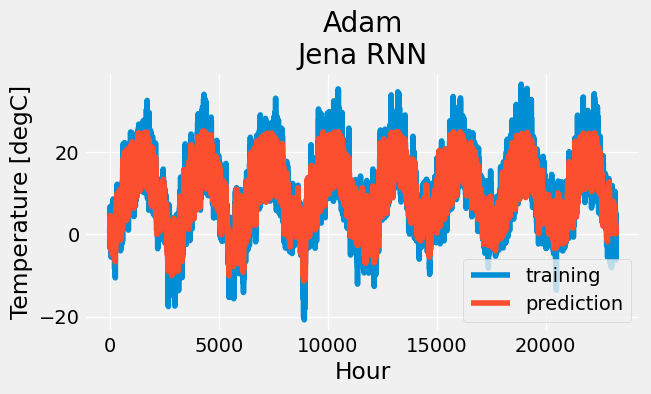

In [14]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(y_train)
plt.plot(p0.flatten())
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.show()

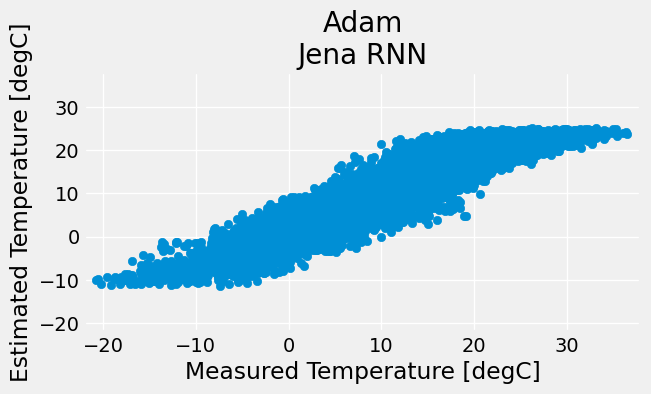

In [15]:
plt.figure(figsize=(13.33, 6.67))
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.xlim([-22,38])
plt.ylim([-22,38])
plt.show()

### Second Model, AdaGrad

In [16]:
%%time
h1,p1=model_build('adagrad')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 838ms/step - loss: 149.5798 - mean_absolute_error: 10.1486 - val_loss: 176.8940 - val_mean_absolute_error: 11.2765
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 761ms/step - loss: 128.5047 - mean_absolute_error: 9.4288 - val_loss: 140.3440 - val_mean_absolute_error: 10.1210
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 669ms/step - loss: 89.7789 - mean_absolute_error: 7.7224 - val_loss: 112.2998 - val_mean_absolute_error: 8.8773
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 734ms/step - loss: 71.9906 - mean_absolute_error: 6.7746 - val_loss: 99.4186 - val_mean_absolute_error: 8.2501
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 696ms/step - loss: 64.1564 - mean_absolute_error: 6.3465 - val_loss: 89.1547 - val_mean_absolute_error: 7.6773
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 618ms/step - loss: 58.6524 - mean_absolute_error: 6.0288 - val_loss: 81.3626 - val_mean_absolute_error: 7.2615
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 698ms/step - loss

### Third Model, Stochastic Gradient Descent with Nesterov Momentum

In [17]:
opt012=tf.keras.optimizers.SGD(momentum=0.5,
                               nesterov=True,
                               name='nSGD'
                              )

In [18]:
%%time
h2,p2=model_build(opt012)

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - loss: 58.6086 - mean_absolute_error: 5.6411 - val_loss: 16.4682 - val_mean_absolute_error: 3.1865
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 16.1482 - mean_absolute_error: 3.1668 - val_loss: 13.7943 - val_mean_absolute_error: 2.9489
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - loss: 13.5916 - mean_absolute_error: 2.9043 - val_loss: 12.0432 - val_mean_absolute_error: 2.7167
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 12.0673 - mean_absolute_error: 2.7336 - val_loss: 12.0929 - val_mean_absolute_error: 2.7150
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 11.5443 - mean_absolute_error: 2.6696 - val_loss: 11.5898 - val_mean_absolute_error: 2.6599
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - loss: 11.0731 - mean_absolute_error: 2.6070 - val_loss: 11.2690 - val_mean_absolute_error: 2.6269
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - loss: 10.7107 -

### Fourth Model, Root Mean Squared Propagation

In [19]:
%%time
h3,p3=model_build('rmsprop')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step - loss: 107.0556 - mean_absolute_error: 8.3032 - val_loss: 59.7268 - val_mean_absolute_error: 6.0796
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - loss: 40.2389 - mean_absolute_error: 4.9000 - val_loss: 38.3450 - val_mean_absolute_error: 4.7521
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 27.9733 - mean_absolute_error: 4.0689 - val_loss: 27.6546 - val_mean_absolute_error: 4.0013
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - loss: 22.4713 - mean_absolute_error: 3.6646 - val_loss: 23.2053 - val_mean_absolute_error: 3.6618
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - loss: 19.4847 - mean_absolute_error: 3.4240 - val_loss: 18.9536 - val_mean_absolute_error: 3.3066
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - loss: 16.9335 - mean_absolute_error: 3.2024 - val_loss: 16.9687 - val_mean_absolute_error: 3.1330
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - loss: 14.67

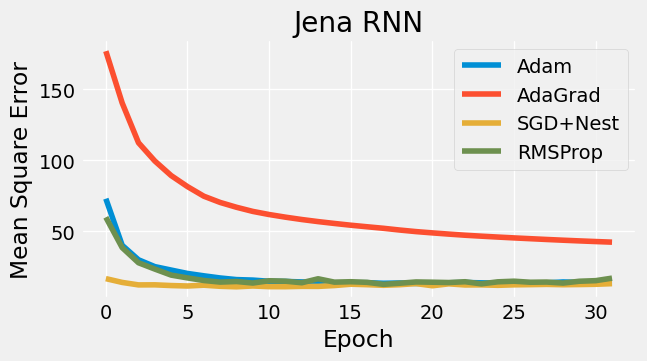

In [20]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSProp'])
plt.title('Jena RNN')
plt.grid(color='white')
plt.show()

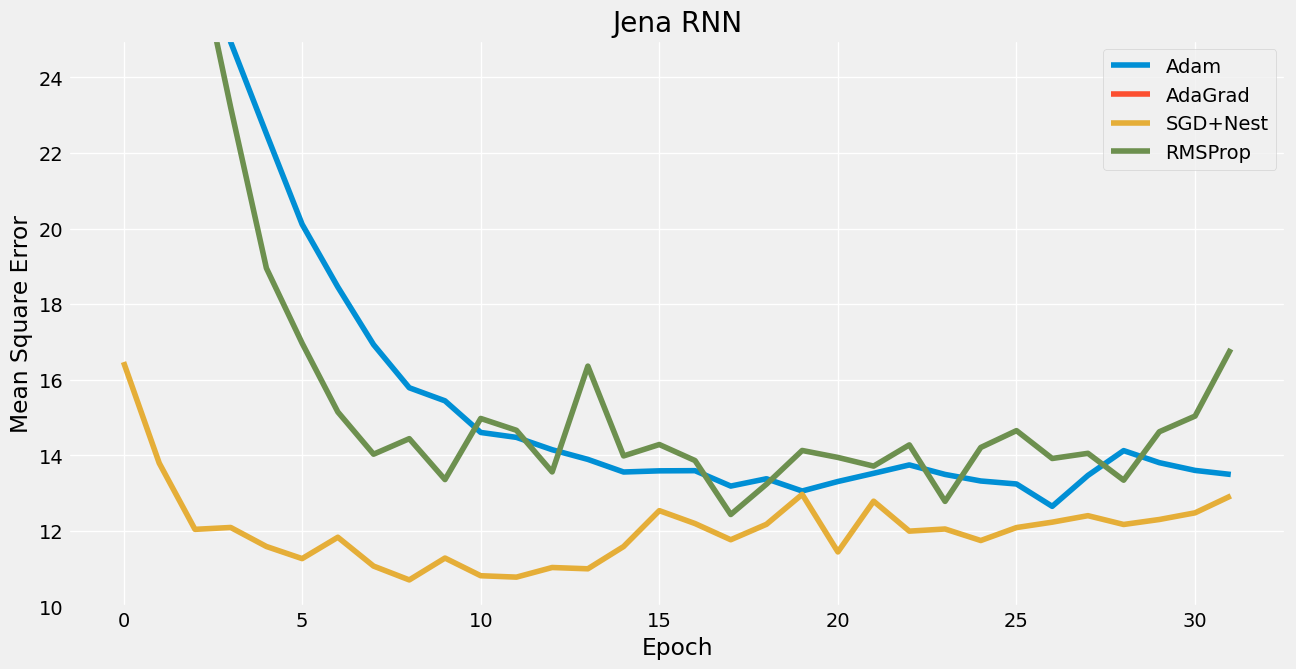

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSProp'])
plt.title('Jena RNN')
plt.ylim([10,25])
plt.grid(color='white')
plt.show()

### Model Summary

In [22]:
m=model_core()
m.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11)             │              23 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,544 (76.35 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 23 (96.00 B)